In [2]:
import sys
dirname = '/Users/muhammaddaffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)
    
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.applications.mixed_integer import (
    MixedIntegerKrigingModel,
)
from smt.surrogate_models import (
    KPLS,
    MixIntKernelType,
    MixHrcKernelType,
)
from smt.explainability_tools import (
    ShapFeatureImportanceDisplay, 
    ShapDisplay,
    PartialDependenceDisplay, 
    PDFeatureImportanceDisplay, 
    PDFeatureInteractionDisplay
)
from sklearn.metrics import mean_squared_error

import numpy as np
import time


In [3]:
# Objective function
def cantilever_deflection(x):
    norm_inertia_vals = [
        0.0833, 0.139, 0.380, 0.0796,
        0.133, 0.363, 0.0859, 0.136,
        0.360, 0.0922, 0.138, 0.369,
    ]
    
    I = int(x[0])
    L = x[1]
    S = x[2]
    norm_inertia = norm_inertia_vals[I]

    E = 200e9
    P = 50e3

    y = (P * L**3) / (3 * E * S**2 * norm_inertia)

    return y

def cantilever_deflection_vectorized(X):
    y = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        y[i] = cantilever_deflection(X[i, :])
    return y

In [4]:
%%time
"""Problem definition"""
# Design space
ds = DesignSpace([
    CategoricalVariable([
        "type_A", "type_B", "type_C", "type_D", 
        "type_E", "type_F", "type_G", "type_H", 
        "type_I", "type_J", "type_K", "type_L",
    ]),
    FloatVariable(10.0, 20.0),
    FloatVariable(1.0, 2.0),
])
categorical_feature_idx = [0]

f_obj = cantilever_deflection

# Create training and testing data
n_data = 1000
n_train = int(0.8 * n_data)
n_test = n_data - n_train
xdoe, _ = ds.sample_valid_x(n_data)
y_doe = [f_obj(xdoe[i]) for i in range(len(xdoe))]

X_tr, y_tr = xdoe[:n_train, :], y_doe[:n_train]
X_te, y_te = xdoe[n_train:, :], y_doe[n_train:]
y_tr, y_te = np.array(y_tr), np.array(y_te)

# Name of the features
feature_names = [r'$I$', r'$L$', r'$S$']

# create mapping for the categories
categories_map = dict()
inverse_categories_map = dict()
for feature_idx in categorical_feature_idx:
    categories_map[feature_idx] = {
        i: value for i, value in enumerate(ds._design_variables[feature_idx].values)
    }
    inverse_categories_map[feature_idx] = {
        value: i for value, i in enumerate(ds._design_variables[feature_idx].values)
    }

CPU times: user 6.24 s, sys: 257 ms, total: 6.49 s
Wall time: 6.52 s


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
X_tr_df = pd.DataFrame(X_tr, columns=["I", "L", "S"])
X_te_df = pd.DataFrame(X_te, columns=["I", "L", "S"])
X_tr_df["I"] = X_tr_df["I"].astype(int).astype(str) 
X_te_df["I"] = X_te_df["I"].astype(int).astype(str) 



In [7]:
class GroundTruthModel:
    def predict_values(self, X):
        return cantilever_deflection_vectorized(X)

model = GroundTruthModel()

In [8]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [9]:
shap_explainer = shap.KernelExplainer(model.predict_values, np.array(X_tr_df))
shap_values = shap_explainer(np.array(X_tr_df))

Using 800 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 800/800 [00:33<00:00, 23.98it/s]


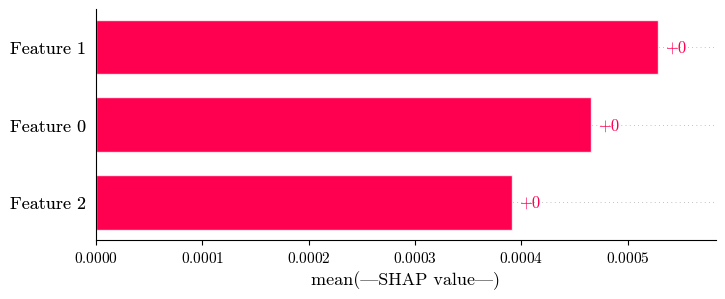

In [10]:
shap.plots.bar(shap_values)

In [14]:
data = shap_values.data[:, 0]
values = shap_values.values[:, 0]

temp = pd.DataFrame({"data": data, "values": values})


In [15]:
grid = [str(i) for i in np.arange(12)]
boxplot_values = []
for i in grid:
    boxplot_values.append(temp["values"].loc[temp["data"]==i])

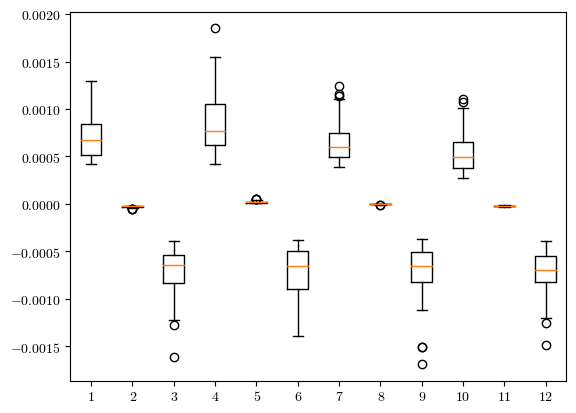

In [16]:
plt.boxplot(boxplot_values)
plt.show()